In [40]:
from ipywidgets import widgets, Layout
from IPython.display import display, Markdown, HTML
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import trapz 
import math
from scipy.stats import norm
import federated_learning
from federated_learning.model import LeNet_Small_Quant

In [50]:
from opacus import PrivacyEngine
import torch

privacy_engine = PrivacyEngine()

privacy_engine = PrivacyEngine()

model = LeNet_Small_Quant()
K = 5
eps = 50
delta = 1e-5
norm = 1.2

(X_train, y_train), (X_test, y_test) = federated_learning.load_cifar10(num_users=1, n_class=10, n_samples=100, rate_unbalance=1.0)
X_train, y_train = X_train[0], y_train[0]
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train)),
    batch_size=32,
    shuffle=True,
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
        
model, optim, train_loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    max_grad_norm=norm,
    noise_multiplier=1.2,
)

Files already downloaded and verified
Files already downloaded and verified


In [51]:
optim.noise_multiplier

1.2

In [35]:
def plot_x(mu=1):
    w = np.linspace(0, 1, 100)
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
  
    plt.grid(color='0.6')
    plt.plot(w,analytical_tpr(w,mu), c="tab:green")
    plt.plot([0,1], [0,1], "--k", label="random guessing")
    plt.title("Trade-off curve")

def analytical_tpr(fpr, mu):
    return 1-norm.cdf(norm.ppf(1-fpr)-mu)

# def calc_privacy_lvl(C, tau, T, n, N, d):
#     K = d
#     n_eff = n + (n*n*tau*tau)/(C*C)
#     mu_step = (d+(2*n-1)*K)/(n_eff*math.sqrt(2*d + 4*((n*n)/n_eff)*K))
#     c = (n*math.sqrt(T))/N
#     mu_tot =  c*fn_dong(mu_step)
#     return mu_tot

def calc_privacy_lvl(C, tau, T, n, N, d, K):
    #print(C, tau, T, n, N, d, K)
    n_eff = n + (n*n*tau*tau)/(C*C)
    #print("neff=", n_eff)
    #mu_step = (d+(2*n_eff-1)*K)/(n_eff*math.sqrt(2*d + 4*n_eff*K))
    mu_step = (d+(2*n-1)*K)/(n_eff*math.sqrt(2*d + 4*((n*n)/n_eff)*K))
    #print("mu_step=", mu_step)
    c = (n*math.sqrt(T))/N
    mu_tot =  c*fn_dong(mu_step)
    return mu_tot

def fn_dong(mus):
    return math.sqrt(2)*math.sqrt(math.exp(mus*mus)*norm.cdf(1.5*mus)+3*norm.cdf(-0.5*mus)-2)
def floater(C):
    try:
        C = math.inf if C == 'inf' else float(C)
    except ValueError:
        C = 1.0
    return C


In [36]:
def wrapper(C, tau, T, n, N, d):
    C = float(C)
    result = calc_privacy_lvl(C, tau, T, n, N, d)
    fpr_values = np.linspace(0, 1, 100)
    tpr_values = [analytical_tpr(fpr, result) for fpr in fpr_values]
    au_roc = trapz(tpr_values, fpr_values)
    tpr_at_001 = tpr_values[np.argmin(np.abs(fpr_values - 0.01))]
    tpr_at_005 = tpr_values[np.argmin(np.abs(fpr_values - 0.05))]
    ## Analycical acc = CDF(0.5*mu)
    acc = norm.cdf(0.5*result)
    print(f"GMIP Privacy Level (mu): {result}")
    print(f"AU-ROC: {au_roc}")
    print(f"TPR@0.01: {tpr_at_001}")
    print(f"TPR@0.05: {tpr_at_005}")
    print('Accuracy:', np.max(acc))
    
    fig, ax = plt.subplots()
    ax.plot(fpr_values, tpr_values, "tab:green", label='TPR vs. FPR')
    ax.fill_between(fpr_values, tpr_values, color="tab:green", step='mid', alpha=0.4)
    ax.plot([0,1], [0,1], "--k", label="random guessing")
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Trade-off Curve')
    ax.legend()
    fig.set_size_inches(3,3)
    plt.show()
    
    

In [8]:
model = LeNet_Small_Quant()
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 74824


GMIP Privacy Level (mu): 0.00019945841355096803
AU-ROC: 0.500056255028675
TPR@0.01: 0.010106374168946664
TPR@0.05: 0.050525790618981326
Accuracy: 0.5000397861971076


/var/folders/k9/sq1przdn1cv5sh7ty2xzg67w0000gn/T/ipykernel_89544/3418556529.py:6: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  au_roc = trapz(tpr_values, fpr_values)


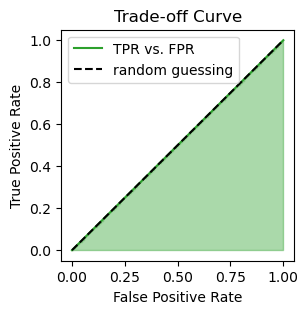

In [33]:
wrapper(C=1.2,
        tau=50,
        T=5,
        n=64,
        N=2500,
        d=74824)

In [39]:
params = {
    "CIFAR10": dict(C=500.0, N=2500, T=5, batch_size=64, K=650, d=650, epochs=5), # 10 epoch with 120 batchs and batch size 400
    "purchase": dict(C=2000.0, N=69*795, T=3*69, batch_size=795, K=2580, d=2580, epochs=3), # We have 69 batches with batch size 795 each in one epoch, train 3 epochs
    "adult": dict(C=800.0, N=43000, T=43*20, batch_size=1000, K=1026, d=1026, epochs=20) # 20 epochs with 43 batches and batch size 1000
}
for key, val_dict in params.items():
    print(f"Privacy guarantee without noise on dataset {key}: mu=", calc_privacy_lvl(val_dict["C"], 0.0, val_dict["T"], val_dict["batch_size"], val_dict["N"], val_dict["d"], val_dict["K"]))

Privacy guarantee without noise on dataset CIFAR10: mu= 12.489026235895498
Privacy guarantee without noise on dataset purchase: mu= 1.4470370595554225
Privacy guarantee without noise on dataset adult: mu= 1.1921696789742704
